---
format: 
  html:
    toc: true
execute:
  echo: true
---

# Interactive Maps with Folium

This page is generated from a Jupyter notebook and shows examples of embedding interactive maps produced using [Folium](https://python-visualization.github.io/folium/latest/).

In [6]:
#| echo: false

import pandas as pd
import geopandas as gpd
import numpy as np


# Hide warnings due to issue in shapely package
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

## Finding the shortest route

This example finds the shortest route between the Art Musuem and the Liberty Bell using [osmnx](https://osmnx.readthedocs.io/en/stable/).

In [ ]:
import osmnx as ox

First, identify the lat/lng coordinates for our places of interest. Use osmnx to download the geometries for the Libery Bell and Art Museum.

In [ ]:
philly_tourism = ox.features_from_place("Philadelphia, PA", tags={"tourism": True})

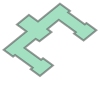

In [ ]:
art_museum = philly_tourism.query("name == 'Philadelphia Museum of Art'").squeeze()

art_museum.geometry

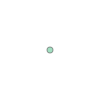

In [ ]:
liberty_bell = philly_tourism.query("name == 'Liberty Bell'").squeeze()

liberty_bell.geometry

Now, extract the lat and lng coordinates

For the Art Museum geometry, we can use the `.geometry.centroid` attribute to calculate the centroid of the building footprint. 

In [13]:
liberty_bell_x = liberty_bell.geometry.x
liberty_bell_y = liberty_bell.geometry.y

In [14]:
art_museum_x = art_museum.geometry.centroid.x
art_museum_y = art_museum.geometry.centroid.y

Next, use osmnx to download the street graph around Center City.

In [12]:
G_cc = ox.graph_from_address(
    "City Hall, Philadelphia, USA", dist=1500, network_type="drive"
)

Next, identify the nodes in the graph closest to our points of interest.

In [15]:
# Get the origin node (Liberty Bell)
orig_node = ox.nearest_nodes(G_cc, liberty_bell_x, liberty_bell_y)

# Get the destination node (Art Musuem)
dest_node = ox.nearest_nodes(G_cc, art_museum_x, art_museum_y)

Find the shortest path, based on the distance of the edges:

In [16]:
# Get the shortest path --> just a list of node IDs
route = ox.shortest_path(G_cc, orig_node, dest_node, weight="length")

How about an interactive version?

`osmnx` has a helper function `ox.utils_graph.route_to_gdf()` to convert a route to a GeoDataFrame of edges.

In [18]:
ox.utils_graph.route_to_gdf(G_cc, route, weight="length").explore(
    tiles="cartodb positron",
    color="red",
)

## Examining Trash-Related 311 Requests

First, let's load the dataset from a CSV file and convert to a GeoDataFrame:

In [19]:
#| code-fold: true

# Load the data from a CSV file into a pandas DataFrame
trash_requests_df = pd.read_csv(
    "https://raw.githubusercontent.com/MUSA-550-Fall-2023/week-4/main/data/trash_311_requests_2020.csv"
)

# Remove rows with missing geometry
trash_requests_df = trash_requests_df.dropna(subset=["lat", "lon"])


# Create our GeoDataFrame with geometry column created from lon/lat
trash_requests = gpd.GeoDataFrame(
    trash_requests_df,
    geometry=gpd.points_from_xy(trash_requests_df["lon"], trash_requests_df["lat"]),
    crs="EPSG:4326",
)

Load neighborhoods and do the spatial join to associate a neighborhood with each ticket:

In [21]:
#| code-fold: true

# Load the neighborhoods
neighborhoods = gpd.read_file(
    "https://raw.githubusercontent.com/MUSA-550-Fall-2023/week-4/main/data/zillow_neighborhoods.geojson"
)

# Do the spatial join to add the "ZillowName" column
requests_with_hood = gpd.sjoin(
    trash_requests,
    neighborhoods.to_crs(trash_requests.crs),
    predicate="within",
)

Let's explore the 311 requests in the Greenwich neighborhood of the city:

In [29]:
# Extract out the point tickets for Greenwich
greenwich_tickets = requests_with_hood.query("ZillowName == 'Greenwich'")

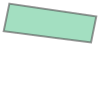

In [30]:
# Get the neighborhood boundary for Greenwich
greenwich_geo = neighborhoods.query("ZillowName == 'Greenwich'")

greenwich_geo.squeeze().geometry

::: {.callout-note}

Quarto has callout blocks that you can use to emphasize content in different ways. This is a "Note" callout block. More info
is available [on the Quarto documentation](https://quarto.org/docs/authoring/callouts.html).

:::

Import the packages we need:

In [27]:
import folium
import xyzservices

Combine the tickets as markers and the neighborhood boundary on the same Folium map:

In [28]:
# Plot the neighborhood boundary
m = greenwich_geo.explore(
    style_kwds={"weight": 4, "color": "black", "fillColor": "none"},
    name="Neighborhood boundary",
    tiles=xyzservices.providers.CartoDB.Voyager,
)


# Add the individual tickets as circle markers and style them
greenwich_tickets.explore(
    m=m,  # Add to the existing map!
    marker_kwds={"radius": 7, "fill": True, "color": "crimson"},
    marker_type="circle_marker", # or 'marker' or 'circle'
    name="Tickets",
)

# Hse folium to add layer control
folium.LayerControl().add_to(m)

m  # show map